# Clustering

## Import Modules

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy

In [2]:
sns.set_palette("colorblind")

## Loading the Dataset

The following steps loads the dataset from the given URL into a pandas dataframe named `df`

In [3]:
songs_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv'

df_main = pd.read_csv(songs_url)

# Creating a copy. Keeping the main df intact in case needed for further analysis
df = df_main.copy()

## Basic Info about the dataset

First, I find the dimensionality of the pandas dataframe using the `df.shape` method. This tells how many rows, columns are there in the dataframe. In this case it is 32833 rows and 23 columns

In [4]:
df.shape

(32833, 23)

Then, I'm exploring the datatypes, count of not-null values in every column of the dataset using the `df.info()` method

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

Also, below is the description of each of the column in the dataset

|variable                 |class     |description |
|:---|:---|:-----------|
|track_id                 |character | Song unique ID|
|track_name               |character | Song Name|
|track_artist             |character | Song Artist|
|track_popularity         |double    | Song Popularity (0-100) where higher is better |
|track_album_id           |character | Album unique ID|
|track_album_name         |character | Song album name |
|track_album_release_date |character | Date when album released |
|playlist_name            |character | Name of playlist |
|playlist_id              |character | Playlist ID|
|playlist_genre           |character | Playlist genre |
|playlist_subgenre        |character | Playlist subgenre|
|danceability             |double    | Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. |
|energy                   |double    | Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. |
|key                      |double    | The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. |
|loudness                 |double    | The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.|
|mode                     |double    | Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.|
|speechiness              |double    | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. |
|acousticness             |double    | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.|
|instrumentalness         |double    | Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. |
|liveness                 |double    | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. |
|valence                  |double    | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). |
|tempo                    |double    | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. |
|duration_ms              |double    | Duration of song in milliseconds |

## Data Preparation

Following actions are taken based on exploratory data analysis. Please check the **EDA notebook** [ipynb](./Srinivasa_Raghavan_Vasanth_Madhavan_EDA.ipynb)|[html](./Srinivasa_Raghavan_Vasanth_Madhavan_EDA.html) for additional details.

### Create Target Variable

In [6]:
# Create a target variable - track_populairy_bin (y)

df['track_popularity_bin'] = np.where( df.track_popularity > 50, 1, 0 )
df = df.astype({'track_popularity_bin': 'object'})
df.track_popularity_bin.value_counts(normalize=True)

track_popularity_bin
0    0.574757
1    0.425243
Name: proportion, dtype: float64

### Data Cleanup

In [7]:
# Drop Duplicates

df.drop_duplicates(subset=['track_id'], keep='first', inplace=True)

In [8]:
# Drop Identifier Columns

df.drop(['track_id','track_album_id','playlist_id','track_artist','playlist_name', 'track_name', 'track_album_name'],
        inplace=True,
        axis=1)

In [9]:
# Drop `track_album_release_date` and `playlist_subgenre`
# playlist_subgenre - because it highly correlates with playlist_genre
# track_album_release_date - because we want to predict popularity of new songs in the playlist


df.drop(columns=['track_album_release_date', 'playlist_subgenre'], inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28356 entries, 0 to 32832
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_popularity      28356 non-null  int64  
 1   playlist_genre        28356 non-null  object 
 2   danceability          28356 non-null  float64
 3   energy                28356 non-null  float64
 4   key                   28356 non-null  int64  
 5   loudness              28356 non-null  float64
 6   mode                  28356 non-null  int64  
 7   speechiness           28356 non-null  float64
 8   acousticness          28356 non-null  float64
 9   instrumentalness      28356 non-null  float64
 10  liveness              28356 non-null  float64
 11  valence               28356 non-null  float64
 12  tempo                 28356 non-null  float64
 13  duration_ms           28356 non-null  int64  
 14  track_popularity_bin  28356 non-null  object 
dtypes: float64(9), int64(4),

## K-Means Clustering

Clustering is an unsupervised machine learning technique designed to group unlabeled examples based on their similarity to each other. For this exercise, we will be using the K-Means method for clustering the given dataset

In [13]:
columns_to_use = ['danceability', 'energy', 'key', 'loudness', 'mode',
                  'speechiness', 'acousticness', 'instrumentalness',
                  'liveness', 'valence', 'tempo', 'duration_ms',
                  'track_popularity_bin', 'playlist_genre']
df_kmeans = df[columns_to_use]

### Preprocessing

In [14]:
df_kmeans.isna().sum()

danceability            0
energy                  0
key                     0
loudness                0
mode                    0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
duration_ms             0
track_popularity_bin    0
playlist_genre          0
dtype: int64

💡 There are no MISSING VALUES in the dataset

In [15]:
df_kmeans_features_clean = df_kmeans.select_dtypes('number').copy()

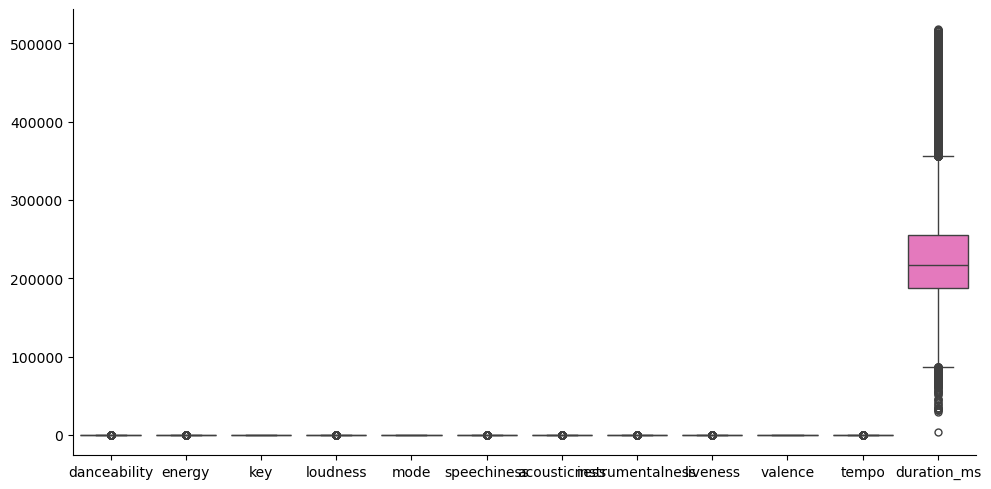

In [16]:
sns.catplot(data = df_kmeans_features_clean, kind='box', aspect=2)

plt.show()

💡 **Since one variable is dominant the data has to be standardized first remove the MAGNITUDE and SCALE effect. KMeans considers SIMILAR to be based on DISTANCE. Distance depends on MAGNITUDE and SCALE**

In [17]:
# Using sklearn StandardScaler to standardize the dataset

X = StandardScaler().fit_transform(df_kmeans_features_clean)

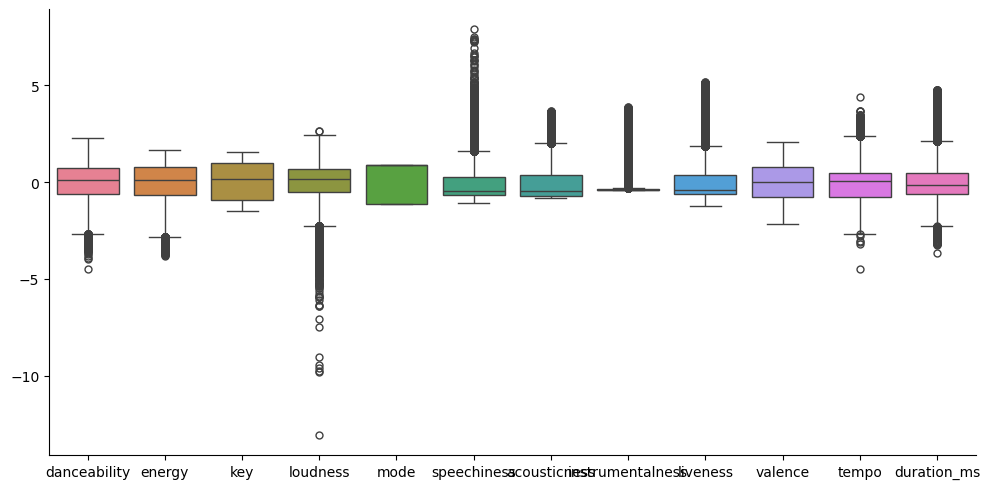

In [18]:
sns.catplot(data = pd.DataFrame(X, columns=df_kmeans_features_clean.columns), kind='box', aspect=2)

plt.show()

📌 Variables have now been standardized

##### Starting with two clusters

In [19]:
clusters_2 = KMeans(n_clusters=2, random_state=121, n_init=25, max_iter=500).fit_predict(X)

In [20]:
df_kmeans_clean_copy = df_kmeans.copy()

In [21]:
df_kmeans_clean_copy['k2'] = pd.Series(clusters_2, index=df_kmeans_clean_copy.index ).astype('category')

In [22]:
df_kmeans_clean_copy.k2.value_counts()

k2
0    20078
1     8278
Name: count, dtype: int64

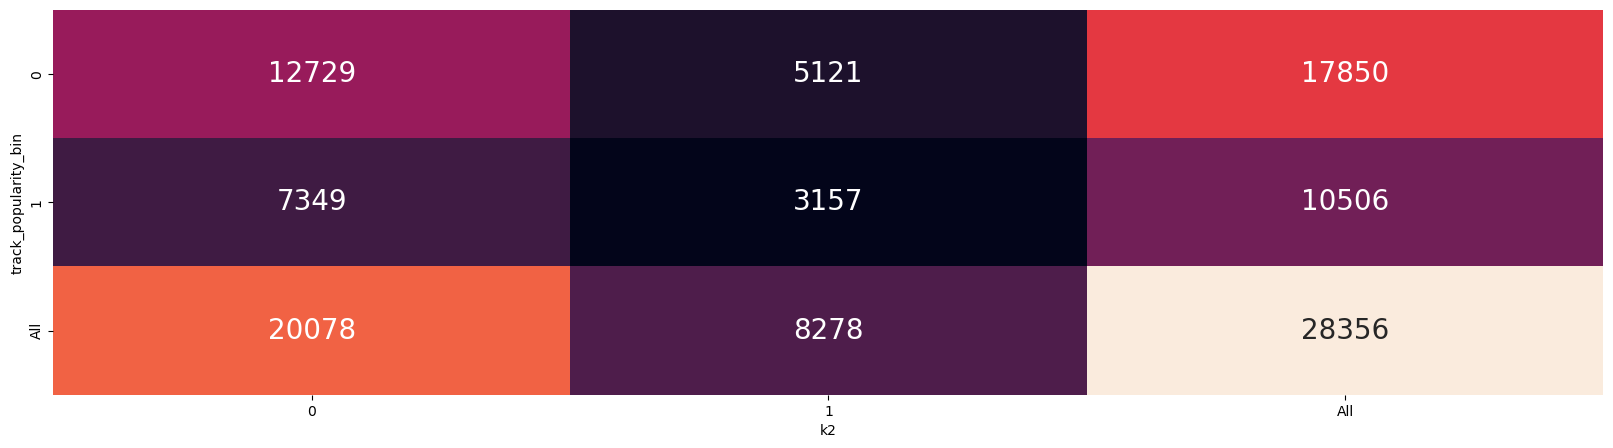

In [23]:
fig, ax = plt.subplots(figsize=(20,5))

sns.heatmap(data = pd.crosstab(df_kmeans_clean_copy.track_popularity_bin,
                               df_kmeans_clean_copy.k2,
                               margins=True ),
            annot=True,
            annot_kws={"fontsize": 20},
            fmt='g',
            cbar=False,
            ax=ax)

plt.show()

The above heatmap tells us that most songs have ended up in cluster 0. This suggests that more clusters are needed to find songs with distinctive characteristics that end up in the popular and unpopular categories

##### Finding Optimal number of clusters

Will be finding optimal number of clusters using the KNEE BEND PLOT!

In [24]:
tots_within = []

K = range(1, 15)

for k in K:
    km = KMeans(n_clusters=k, random_state=121, n_init=25, max_iter=500)
    km = km.fit(X)
    tots_within.append( km.inertia_ )

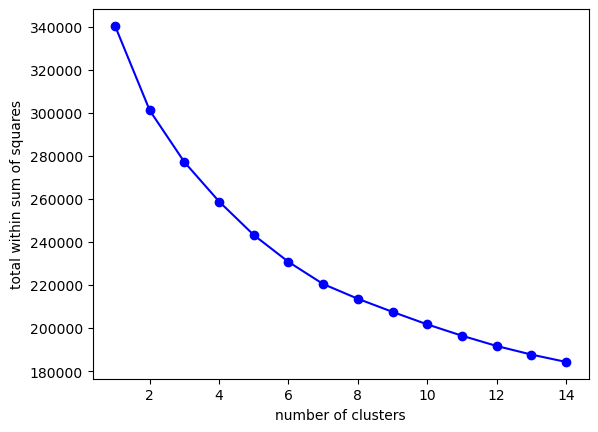

In [25]:
fig, ax = plt.subplots()

ax.plot( K, tots_within, 'bo-' )
ax.set_xlabel('number of clusters')
ax.set_ylabel('total within sum of squares')

plt.show()

📌 **Although, there isn't a clean KNEE BEND here we can see that the plot starts to bend around the cluster value of 5 and is prominent before 8. So, I have decided to go with 7 clusters for further analysis**

In [26]:
clusters_7 = KMeans(n_clusters=7, random_state=121, n_init=25, max_iter=500).fit_predict(X)

In [27]:
df_kmeans_clean_copy = df_kmeans.copy()

In [28]:
df_kmeans_clean_copy['k7'] = pd.Series(clusters_7, index=df_kmeans_clean_copy.index ).astype('category')

In [29]:
df_kmeans_clean_copy.k7.value_counts()

k7
3    6844
4    5963
2    5038
6    3510
5    3123
0    2211
1    1667
Name: count, dtype: int64

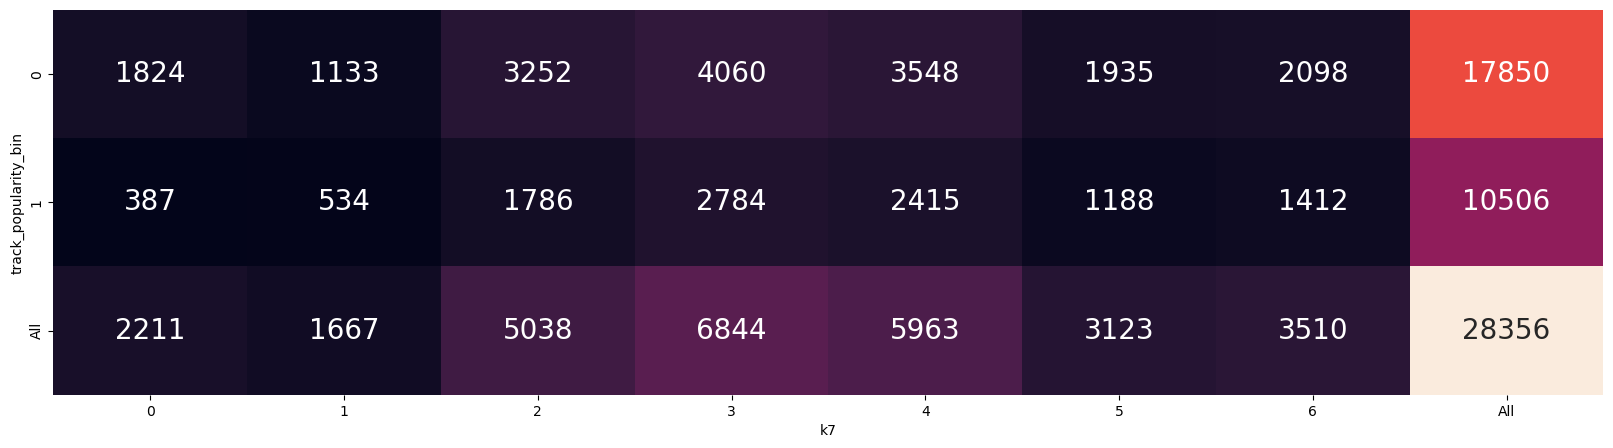

In [30]:
fig, ax = plt.subplots(figsize=(20,5))

sns.heatmap(data = pd.crosstab(df_kmeans_clean_copy.track_popularity_bin,
                               df_kmeans_clean_copy.k7,
                               margins=True ),
            annot=True,
            annot_kws={"fontsize": 20},
            fmt='g',
            cbar=False,
            ax=ax)

plt.show()

💡 **The above heatmap tells that clusters 0,1,2 tend to have more unpopular songs than clusters 3,4,5,6. This is much better than two clusters**

#### Visualizing relationships and conditional distributions using PAIR PLOT

Finally, using PAIR PLOT to visualize the relationships between continuous variables GROUPED BY the cluster category as well as conditional distribution of each continuous variable GROUPED BY the cluster category

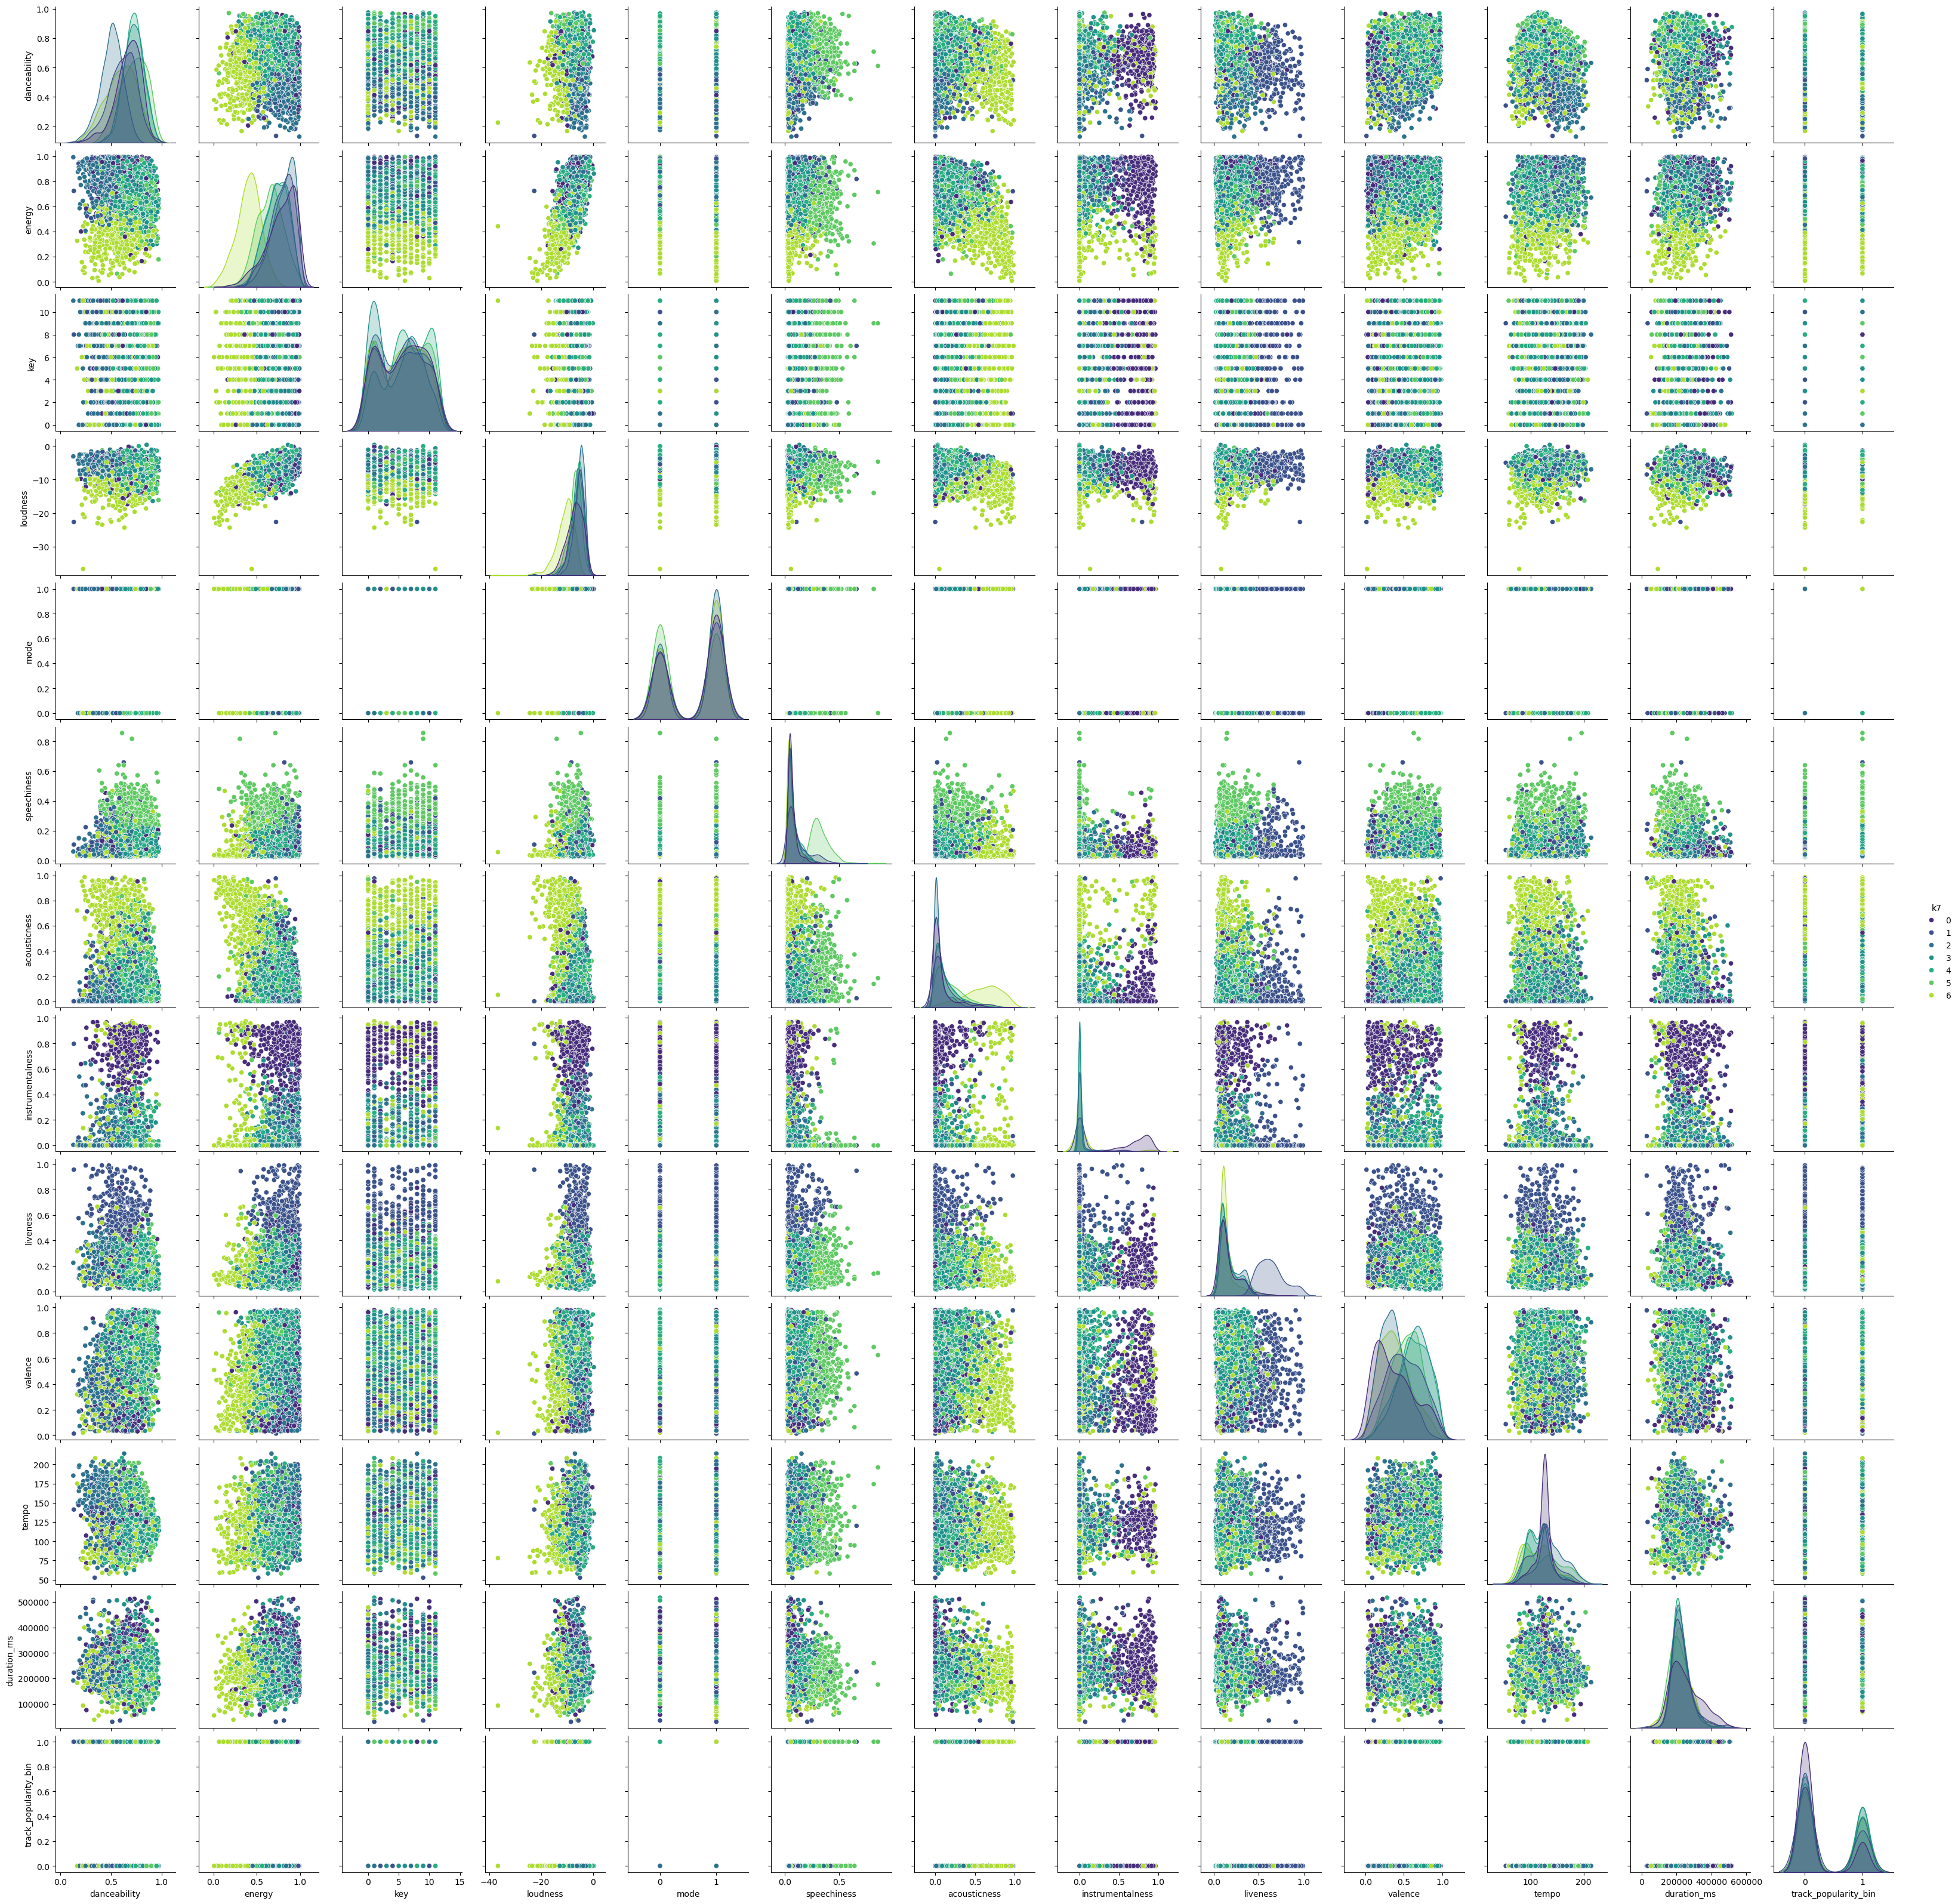

In [ ]:
# NOTE: I have used a sample of 5000 because my notebook kept crashing
sns.pairplot(data = df_kmeans_clean_copy.sample(5000), hue='k7', diag_kws={'common_norm': False},
             palette='viridis')

plt.show()

💡 **Observations**

1. Tracks in the clusters 0,1,2 tend to have higher `energy` compared to the clusters 3,4,5,6
2. Tracks in cluster 5 have lower `energy` and `duration_ms` between 200000 and 300000
3. Cluster 0 seems to be made of tracks with high `instrumentalness` and high `energy`


## Hierarchical Clustering

### Plotting the dendrogram

In [32]:
hclust_ward = hierarchy.ward(X)

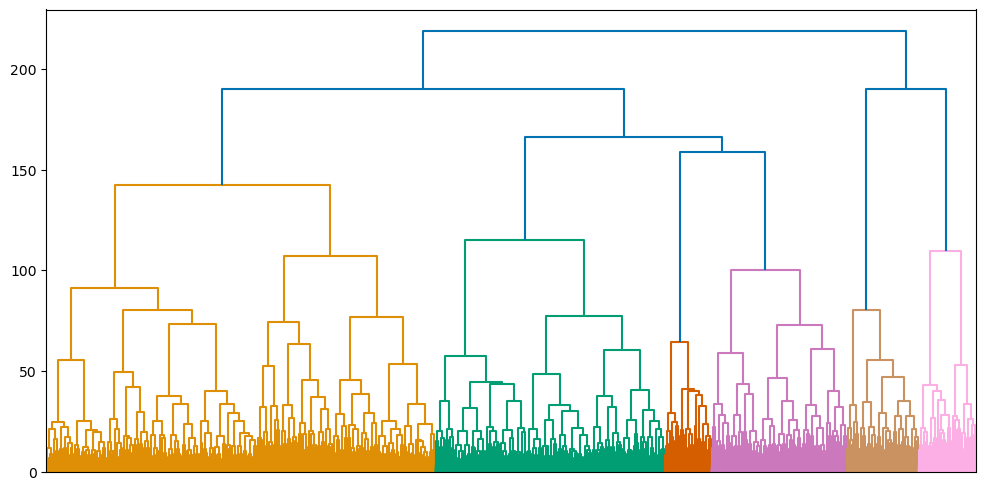

In [33]:
fig = plt.figure(figsize=(12, 6))

dn = hierarchy.dendrogram(hclust_ward, no_labels=True )

plt.show()

In [34]:
np.unique( hierarchy.cut_tree( hclust_ward, height=180).ravel() )

array([0, 1, 2, 3])

In [35]:
df_kmeans_clean_copy['hclust_4'] = pd.Series( hierarchy.cut_tree( hclust_ward, height=180).ravel(),
                                              index=df_kmeans_clean_copy.index ).astype('object')

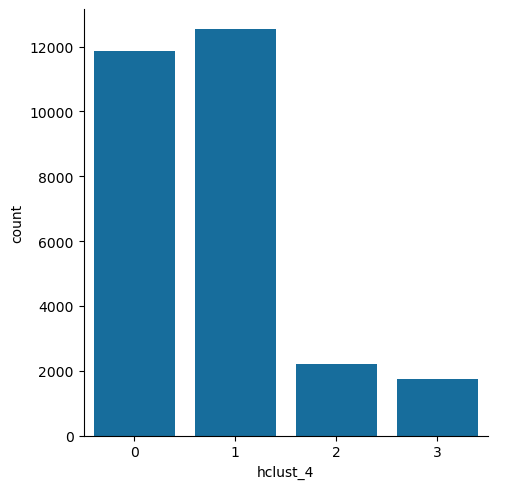

In [36]:
sns.catplot(data = df_kmeans_clean_copy, x='hclust_4', kind='count')

plt.show()

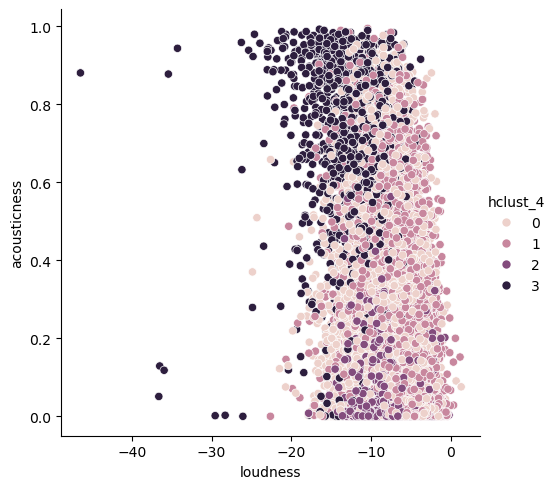

In [37]:
sns.relplot(data = df_kmeans_clean_copy, x='loudness', y='acousticness', hue='hclust_4')

plt.show()

### Cluster Analysis

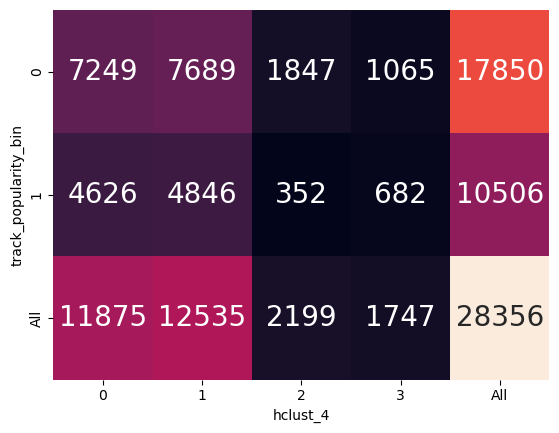

In [38]:
fig, ax = plt.subplots()

sns.heatmap(
    data = pd.crosstab(
        df.track_popularity_bin, df_kmeans_clean_copy.hclust_4, margins=True,
    ),
    annot=True,
    annot_kws={'fontsize': 20}, fmt='g',
    cbar=False,
    ax=ax)

plt.show()

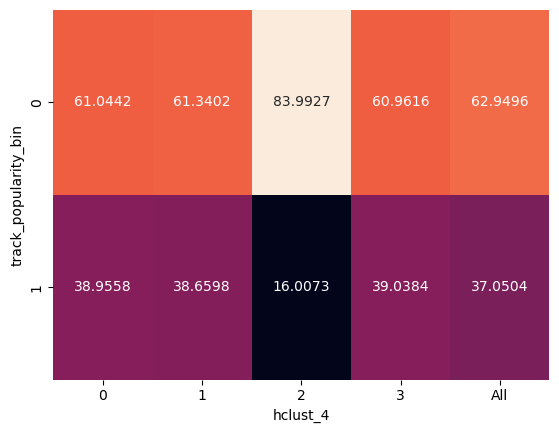

In [39]:
fig, ax = plt.subplots()

sns.heatmap(
    data = pd.crosstab(
        df.track_popularity_bin, df_kmeans_clean_copy.hclust_4, margins=True, normalize='columns'
    )*100,
    annot=True,
    annot_kws={'fontsize': 10}, fmt='g',
    cbar=False,
    ax=ax)

plt.show()

💡 **Cluster 2** has the highest percentage of unpopular songs

In [40]:
# Reshape to long format to enable exploring ALL of the original variables GROUPED BY the clusters!

df_kmeans_clean_copy_lf = df_kmeans_clean_copy.reset_index().\
rename(columns={'index': 'rowid'}).\
melt(id_vars=['rowid', 'k7', 'hclust_4', 'track_popularity_bin'],
     value_vars=df_kmeans_features_clean[
         ['danceability', 'energy', 'key', 'loudness', 'mode', 
          'speechiness', 'acousticness', 'instrumentalness', 
          'liveness', 'valence', 'tempo', 'duration_ms', 
          ]])

In [41]:
df_kmeans_clean_copy_lf

rowid k7 hclust_4 track_popularity_bin      variable       value
0           0  3        0                    1  danceability       0.748
1           1  3        0                    1  danceability       0.726
2           2  4        1                    1  danceability       0.675
3           3  2        0                    1  danceability       0.718
4           4  3        0                    1  danceability       0.650
...       ... ..      ...                  ...           ...         ...
340267  32828  2        0                    0   duration_ms  204375.000
340268  32829  2        0                    0   duration_ms  353120.000
340269  32830  2        1                    0   duration_ms  210112.000
340270  32831  2        0                    0   duration_ms  367432.000
340271  32832  1        1                    0   duration_ms  337500.000

[340272 rows x 6 columns]

In [ ]:
sns.catplot(data = df_kmeans_clean_copy_lf[['hclust_4','variable','value']], 
            x='hclust_4', 
            y='value', 
            col='variable', 
            col_wrap=3,
            kind='box',
            sharey=False)

plt.show()

### 💡 Analysis of Boxplots by Clusters
1. **Danceability**
- Fairly consistent across clusters, with slight variations in medians and ranges.
- Most clusters have similar distributions, with some outliers.

2. **Energy**
- Significant variation across clusters.
- 👀 **cluster 3** has noticeably lower energy values compared to others.

3. **Key**
- Distributions appear consistent across clusters.
- Clusters do not show strong separation based on the **key**.

4. **Loudness**
- Slight variation in medians across clusters.

5. **Mode**
- 👀 Clear separation exists for this feature across clusters.

6. **Speechiness**
- Low values dominate most clusters, with a few clusters showing greater variability and high outliers.

7. **Acousticness**
- 👀 Strong differences across clusters.
- Some clusters have consistently high values, while others are lower.

8. **Instrumentalness**
- 👀 Significant variation across clusters.
- Some clusters have higher median values and larger ranges for this feature.

9. **Liveness**
- Variability in medians and ranges exists, but differences are not extreme.

10. **Valence**
- Distribution is relatively uniform across clusters.
- Slight variations in medians are observed.

11. **Tempo**
- Clear differences in medians and ranges across clusters.
- 👀 **Cluster 2** interquartile range (IQR) is very narrow compared to ther three clusters. This clearly confirms clustering of slower songs in this cluster.

12. **Duration (ms)**
- Significant separation across clusters.
- 👀 **Cluster 2** has consistently higher durations than others.

**General Insights**
1. **Distinct Clustering Features**:  
   - 💓 Features like **instrumentalness**, **duration_ms**, **acousticness**, **energy** and **tempo** show clear separation across clusters, making them key drivers of clustering.
2. **Uniform Features**:  
   - Features like **key** and **danceability** have consistent distributions, contributing less to cluster differentiation.
3. **Categorical Variables**:  
   - Features like **mode** separate clusters clearly due to their binary nature.



In [ ]:
sns.pairplot(data=df_kmeans_clean_copy[['danceability', 'energy', 'key', 'loudness', 'mode', 
                                        'speechiness', 'acousticness', 'instrumentalness', 
                                        'liveness', 'valence', 'tempo', 'duration_ms','hclust_4']],
             hue='hclust_4', 
             diag_kws={'common_norm': False}, 
             palette='viridis')

plt.show()

-------------------